In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [4]:
df1 = pd.read_csv("01 Oxidation.csv")
df2 = pd.read_csv("02 Photo_softbake.csv")
df3 = pd.read_csv("03 Photo_lithograpy.csv")
df4 = pd.read_csv("04 Etching.csv")
df5 = pd.read_csv("05 Ion_Implantation.csv")
df6 = pd.read_csv("06 Inspect.csv")

In [5]:
df = pd.merge(df1, df2, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df3, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df4, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df5, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df6, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])

In [6]:
df.dropna(subset="Thin F2", inplace=True) # 다른 변수들과의 연관성을 찾지못함, 한 행에 여러 열들 결측값 가짐
# pd.set_option('display.max_row', 200)
# pd.set_option('display.max_columns', 200)

In [7]:
df['Ox_Chamber'] = df['Ox_Chamber'].astype('str')
df['photo_soft_Chamber'] = df['photo_soft_Chamber'].astype('str')
df['lithography_Chamber'] = df['lithography_Chamber'].astype('str')
df['Etching_Chamber'] = df['Etching_Chamber'].astype('str')
df['Chamber_Num'] = df['Chamber_Num'].astype('str')
df['path'] = df['Ox_Chamber']+df['photo_soft_Chamber']+df['lithography_Chamber']+df['Etching_Chamber']+df['Chamber_Num']

In [8]:
df.drop(df[df['Oxid_time']<0].index, inplace=True) # 산화시간이 음수
df.drop(df[df['Target']==0].index, inplace=True) # target 값이 0
df.drop(columns = ["Wafer_map","Error_message"],inplace=True) # 웨이퍼맵, 에러메시지

In [9]:
# 시간 데이터 datetime 유형으로 변환
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y')

# 195이상 = 불량(1), 195미만 = 양품(0)
df.loc[df['Target'] >= 195, '불량_195이상'] =1
df.loc[df['Target'] < 195, '불량_195이상'] =0

In [10]:
df.loc[df['Thin F4']<0, 'Thin F4']=df['Thin F4'].median()
df.loc[df['Flux90s']<0, 'Flux90s']=df['Flux90s'].median()
df.loc[df['Flux160s']<0, 'Flux160s']=df['Flux160s'].median()
df.loc[df['Flux160s']<5, 'Flux160s']=df['Flux160s'].median()

In [11]:
df['Thin F1'].fillna(df['Thin F1'].median(), inplace=True)
df['Thin F3'].fillna(df['Thin F3'].median(), inplace=True)
df['Flux60s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux90s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux480s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux840s'].fillna(df['Flux90s'].median(), inplace=True)

### 불필요한 열 제거

In [12]:
# 불필요한 열 제거 
# df.drop(columns=["No_Die", "Lot_Num", "Wafer_Num"], inplace=True)
df.drop(columns=['Vapor','process','Wavelength'])
df.loc[df['Flux840s'] == 8.137500e+16, 'Flux840s'] = df['Flux840s'].mode()[0]
df.loc[df['Flux480s'] == 8.137500e+16, 'Flux480s'] = df['Flux480s'].mode()[0]

In [13]:
df_new = df[['Temp_OXid','ppm','Pressure','type','Oxid_time',
        'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
       'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake',
       'temp_softbake', 'time_softbake', 'UV_type', 'Energy_Exposure',       
        'Temp_Etching', 'Source_Power',
       'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp',
       '불량_195이상', 'path']]

In [14]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
#분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [15]:
df_raw_dummy = pd.get_dummies(df_new).astype(int)

df_raw_x = df_raw_dummy.drop("불량_195이상", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["불량_195이상"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (1693, 108)
분할 후 설명변수 데이터 :Train (1185, 108)   Test (508, 108)


In [15]:
rf_uncust = RandomForestClassifier(random_state=1234)
rf_uncust.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(rf_uncust.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_uncust.score(df_test_x, df_test_y)))

Accuracy on training set: 0.999
Accuracy on test set: 0.927


In [17]:
estimator = RandomForestClassifier(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": [3,5,7,9,11,13],
              "min_samples_leaf": [5,7,9,11,13,15,20],
              "n_estimators" : [100, 150, 200, 250, 300],
              "min_samples_split": [2,3,5,7,8],
              "bootstrap": [True, False]
              }
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(bootstrap=False, max_depth=9, min_samples_leaf=5,
                       n_estimators=250, random_state=1234)

best parameter: 
{'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 250}

best score: 
0.941


In [16]:
rf_final=RandomForestClassifier(bootstrap=False, max_depth=9, min_samples_leaf=5,
                       n_estimators=250, random_state=1234)

rf_final.fit(df_train_x, df_train_y)
y_pred = rf_final.predict(df_test_x)

print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.950
Accuracy on test set: 0.927

Confusion matrix: 
[[463   1]
 [ 36   8]]
              precision    recall  f1-score   support

           0      0.928     0.998     0.962       464
           1      0.889     0.182     0.302        44

    accuracy                          0.927       508
   macro avg      0.908     0.590     0.632       508
weighted avg      0.924     0.927     0.904       508



In [17]:
v_feature_names = df_train_x.columns

df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
18,input_Energy,0.100
11,spin3,0.097
0,Temp_OXid,0.083
20,Furance_Temp,0.072
3,Oxid_time,0.061
...,...,...
79,path_23322,0.000
61,path_21322,0.000
77,path_23233,0.000
70,path_22322,0.000


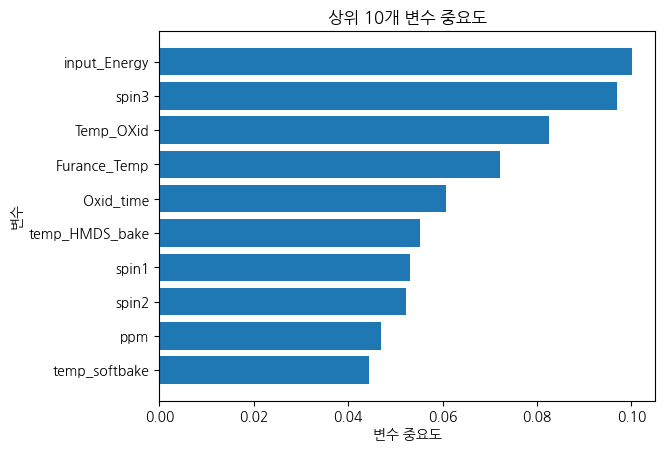

In [18]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
top_10_importance = df_importance.nlargest(10, "Importance")

# 시각화
coordinates = range(len(top_10_importance))
plt.barh(y=coordinates[::-1], width=top_10_importance["Importance"])
plt.yticks(coordinates[::-1], top_10_importance["Feature"], fontsize=10)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.title("상위 10개 변수 중요도")
plt.show()

In [19]:
df['불량_195이상'].value_counts()

불량_195이상
0.0    1572
1.0     121
Name: count, dtype: int64

### SMOTE

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [21]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_train_x, df_train_y)
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(df_test_x)
print(classification_report(df_test_y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       464
           1       0.69      0.45      0.55        44

    accuracy                           0.94       508
   macro avg       0.82      0.72      0.76       508
weighted avg       0.93      0.94      0.93       508



In [22]:
estimator = RandomForestClassifier(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": [3,5,7,9,11,13],
              "min_samples_leaf": [5,7,9,11,13,15,20],
              "n_estimators" : [100, 150, 200, 250, 300],
              "min_samples_split": [2,3,5,7,8],
              "bootstrap": [True, False]
              }
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(X_resampled, y_resampled)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(bootstrap=False, max_depth=13, min_samples_leaf=5,
                       n_estimators=200, random_state=1234)

best parameter: 
{'bootstrap': False, 'max_depth': 13, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}

best score: 
0.971


In [25]:
rf_clf = RandomForestClassifier(bootstrap=False, max_depth=13, min_samples_leaf=5,
                       n_estimators=200, random_state=1234)
rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(df_test_x)
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred))

Confusion matrix: 
[[452  12]
 [ 25  19]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       464
           1       0.61      0.43      0.51        44

    accuracy                           0.93       508
   macro avg       0.78      0.70      0.73       508
weighted avg       0.92      0.93      0.92       508

